### 讀入基本套件 ###

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [2]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

### 資料預處理 ###

In [3]:
(x_train, y_train0), (x_test, y_test0) =  datasets.fashion_mnist.load_data() 

In [4]:
x_train = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(-1, x_test.shape[1]*x_test.shape[2])

x_train = x_train/x_train.max()
x_test = x_test/x_test.max()

y_train = to_categorical(y_train0)
y_test = to_categorical(y_test0)

### 更改模型參數以及數量 ###

In [5]:
enc_1 = Dense(500, activation = 'relu')
enc_2 = Dense(250, activation = 'relu')
enc_3 = Dense(50, activation = 'relu')

mean = Dense(2)
log_var = Dense(2)

dec_1 = Dense(50, activation = 'relu')
dec_2 = Dense(250, activation = 'relu')
dec_3 = Dense(500, activation = 'relu')
dec_4 = Dense(x_train.shape[1], activation = 'sigmoid')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
x = Input(shape = (784,))
enc_f1 = enc_1(x)
enc_f2 = enc_2(enc_f1)
enc_f3 = enc_3(enc_f2)

z_mean = mean(enc_f3)
z_log_var = log_var(enc_f3)

### 定義抽樣方法 ###

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [9]:
dec_f1 = dec_1(z)
dec_f2 = dec_2(dec_f1)
dec_f3 = dec_3(dec_f2)
x_hat = dec_4(dec_f3)


In [10]:
vae_model = Model(x, x_hat)

In [11]:
vae_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 250)          125250      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           12550       dense_1[0][0]                    
______________________________________________________________________________________________

### 定義loss function ###

In [12]:
new_loss = x_train.shape[1] * losses.mean_squared_error(x, x_hat)

kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
kl_loss = K.sum(kl_loss, axis = 1)

vae_loss = K.mean(new_loss + kl_loss)
vae_model.add_loss(vae_loss)

In [13]:
vae_model.compile(optimizer = Adam())

In [14]:
vae_model.fit(x_train, batch_size = 100, epochs = 15)

Epoch 1/15
60000/60000 [==============================] - 6s 105us/sample - loss: 38.8021
Epoch 2/15
60000/60000 [==============================] - 6s 92us/sample - loss: 30.6892
Epoch 3/15
60000/60000 [==============================] - 6s 92us/sample - loss: 29.2676
Epoch 4/15
60000/60000 [==============================] - 6s 92us/sample - loss: 28.4961
Epoch 5/15
60000/60000 [==============================] - 6s 93us/sample - loss: 28.1129
Epoch 6/15
60000/60000 [==============================] - 6s 93us/sample - loss: 27.7446
Epoch 7/15
60000/60000 [==============================] - 6s 93us/sample - loss: 27.4028
Epoch 8/15
60000/60000 [==============================] - 6s 92us/sample - loss: 27.2755
Epoch 9/15
60000/60000 [==============================] - 6s 93us/sample - loss: 27.0770
Epoch 10/15
60000/60000 [==============================] - 6s 93us/sample - loss: 26.8447
Epoch 11/15
60000/60000 [==============================] - 6s 92us/sample - loss: 26.6697
Epoch 12/15
60000/

### encoder model ###

In [15]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12550     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 530,402
Trainable params: 530,402
Non-trainable params: 0
_________________________________________________________________


### decoder model ###

In [16]:
z_input = Input(shape = (2,))
VAE_Decoder = Model(z_input, dec_4(dec_3(dec_2(dec_1(z_input)))))

VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_6 (Dense)              (None, 250)               12750     
_________________________________________________________________
dense_7 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               392784    
Total params: 531,184
Trainable params: 531,184
Non-trainable params: 0
_________________________________________________________________


### 抽取5000樣本 畫平均數分布圖 ###

In [17]:
indices = np.random.randint(x_train.shape[0], size=5000)

In [18]:
VAE_latents = VAE_Encoder.predict(x_train[indices])

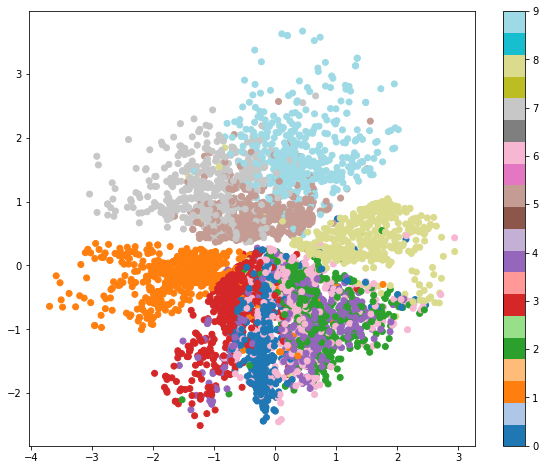

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

### 隨機取2張圖，看其變化 ###

In [20]:
from ipywidgets import interact, IntSlider, FloatSlider

In [21]:
idx_1, idx_2 = np.random.randint(x_train.shape[0], size=2)

In [22]:
def inBetween(t):
    data_0 = x_train[idx_1].reshape(28, 28)
    data_1 = x_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])
    
    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')
    
    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')
    
    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [23]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>